ChEn-5310: Computational Continuum Transport Phenomena Fall 2021 UMass Lowell; Prof. V. F. de Almeida **28Oct21**

# 01a. Python FEM Basis Functions
$  
  \newcommand{\Amtrx}{\boldsymbol{\mathsf{A}}}
  \newcommand{\Gmtrx}{\boldsymbol{\mathsf{G}}}
  \newcommand{\Bmtrx}{\boldsymbol{\mathsf{B}}}
  \newcommand{\Mmtrx}{\boldsymbol{\mathsf{M}}}
  \newcommand{\Imtrx}{\boldsymbol{\mathsf{I}}}
  \newcommand{\Pmtrx}{\boldsymbol{\mathsf{P}}}
  \newcommand{\Lmtrx}{\boldsymbol{\mathsf{L}}}
  \newcommand{\Umtrx}{\boldsymbol{\mathsf{U}}}
  \newcommand{\Smtrx}{\boldsymbol{\mathsf{S}}}
  \newcommand{\xvec}{\boldsymbol{\mathsf{x}}}
  \newcommand{\avec}{\boldsymbol{\mathsf{a}}}
  \newcommand{\bvec}{\boldsymbol{\mathsf{b}}}
  \newcommand{\cvec}{\boldsymbol{\mathsf{c}}}
  \newcommand{\rvec}{\boldsymbol{\mathsf{r}}}
  \newcommand{\fvec}{\boldsymbol{\mathsf{f}}}
  \newcommand{\mvec}{\boldsymbol{\mathsf{m}}}
  \newcommand{\gvec}{\boldsymbol{\mathsf{g}}}
  \newcommand{\zerovec}{\boldsymbol{\mathsf{0}}}
  \newcommand{\norm}[1]{\bigl\lVert{#1}\bigr\rVert}
  \newcommand{\transpose}[1]{{#1}^\top}
  \DeclareMathOperator{\rank}{rank}
  \newcommand{\Reals}{\mathbb{R}}
  \newcommand{\thetavec}{\boldsymbol{\theta}}
$

---

## Table of Contents<a id="toc"></a>
* [Objectives](#obj)
* [Finite Element Lagrange Polynomial Basis Functions](#fem-lagrange-basis)
 1. [Domain Partition](#dom-part)
 2. [Parent Mapping](#parent-map)
 3. [Parent Basis Functions (or also called shape functions)](#parent-basis)
 4. [Global Basis Functions](#global-basis)
 5. [Testing](#test)
* [Function Approximation](#func-approx)
 + [Inner Product](#inner-prod)
 + [Gram Matrix](#gram-matrix)
 + [Load Vector](#load-vector)
 + [Optimal Combination Coefficients](#cont-optimal-coeff)
 + [Results](#cont-res)
---

## [Objectives](#toc)<a id="obj"></a>

 + Present basic `python` code that implements finite element basis functions mathematical structures (notes: [OneNote Engy-5310-fem-basis-func](https://studentuml-my.sharepoint.com/:o:/g/personal/valmor_dealmeida_uml_edu/Evw7drHQs_ZMqvRqjb762w8BtVaiw2QrQKjQwYf6qCN4Sg?e=v6nG9O)).
 + Review the fundamental mathematical elements of the finite element basis functions theory.
 + Demonstrate function approximation via Lagrange finite element basis functions of degree 1. It is left as an exercise to extend the `python` functions below to degrees 2 and 3. Note: only minor modification is needed beyond coding the parent basis functions for higher-order degree.

## [Finite Element Lagrange Basis Functions](#toc)<a id="fem-lagrange-basis"></a>

The following subsections follow the ordered presentation of the theory. 
The `python` code below can be extended to higher degree Lagrange polynomials. It is left as an exercise for the reader.
Only minor changes are needed. The point of the implementation below is to present the major components of a program that implements the basic theory of the finite element method. The course notes should be reviewed in addition to the `python` code below.

### [1) Domain Partition](#toc)<a id="dom-part"></a>

The very first structure needed is the domain partition. Build the domain partition artifacts. This can be easily extended to higher order partitions (higher degree) to include interior nodes in the domain patches (or elements). Therefore a partition needs to be aware of the degree of polynomials to be distributed over the domain. Also, here the boundary conditions should be used to flag nodes where no basis functions will be placed.

In [1]:
'''Domain partition'''
def get_domain_partition(degree, n_elem, x_min, x_max, bc_x_min='flux', bc_x_max='flux'):
    assert degree == 1
    # Local node numbering on parent domain
    # --0--------------1---->
    #  -1      0      +1    zeta
    gnodes_x = np.linspace(x_min, x_max, n_elem+1, dtype=np.float64)
    patches = list()
    local_to_global_node_id_map = list()
    for e in range(n_elem):
        gnode_id_2 = e + 1            # right
        gnode_id_1 = gnode_id_2 - 1   # left
        x1 = gnodes_x[gnode_id_1]
        x2 = gnodes_x[gnode_id_2]
        # Local node id:  0   1
        patches.append((x1, x2))
        # Local node id:                        0           1
        local_to_global_node_id_map.append([gnode_id_1, gnode_id_2])
    if bc_x_min == 'essential':
        local_to_global_node_id_map[0][0] = -1
    if bc_x_max == 'essential':
        local_to_global_node_id_map[-1][-1] = -1
    return (patches, gnodes_x, local_to_global_node_id_map)

### [2) Parent Mapping](#toc)<a id="parent-map"></a>

The parent mapping is not a function of the degree of the Lagrange polynomials unless the domain is curved and an isoparametric mapping is used (this is not covered in this course yet). The foregoing makes the parent mapping the second structured needed.

In [2]:
'''Parent mapping'''
def get_parent_mapping():
    # zeta in [-1,1]
    parent_mapping = lambda zeta, x_e_bar, h_e: x_e_bar + h_e/2*zeta # compute x
    parent_mapping_prime = lambda h_e: h_e/2                           # compute mapping derivative wrt zeta
    # x in Omega_e
    inverse_parent_mapping = lambda x, x_e_bar, h_e: (x - x_e_bar)*2/h_e # compute zeta
    return (parent_mapping, parent_mapping_prime, inverse_parent_mapping)

### [3) Parent Basis Functions](#toc)<a id="parent-basis"></a>

Construct the parent basis functions. Again, the course notes should be followed to extend this to higher degree Lagrange polynomials, and/or h-p adaptivity.

In [3]:
'''Parent basis functions'''
def get_parent_basis_functions():
    parent_basis_func_list = list()
    parent_basis_func_prime_list = list()
    parent_basis_func_list.append(lambda zeta: -(zeta-1)/2)  # left
    parent_basis_func_list.append(lambda zeta:  (zeta+1)/2)  # right
    parent_basis_func_prime_list.append(lambda zeta: -1/2) # left
    parent_basis_func_prime_list.append(lambda zeta:  1/2) # right
    
    return (parent_basis_func_list, parent_basis_func_prime_list)

### [4) Global Basis Functions](#toc)<a id="global-basis"></a>

A global finite element basis function is never constructed but here it is demonstrated how it can be done so the theory is proven numerically. The `python` functions below requires only minor changes when extended for higher degree Lagrange polynomials, and/or rudimentary h-p adaptivity.

In [4]:
'''Any global basis function'''
def global_basis_function(i, x, domain_partition, parent_mapping, parent_basis_functions):
    """Evaluate the ith global FE basis function and its derivative on x points.
    
    This is never needed in practice. It is here for demonstrating the theory.
    """
  
    try:
        len(x)
    except TypeError:
        x = np.array([x])
  
    if not isinstance(x, np.ndarray):
       assert isinstance(x, list) or isinstance(x, tuple)
       x = np.array(x)
  
    phi_i_x = np.copy(x) * 0.0 # initialization
    phi_prime_i_x = np.copy(x) * 0.0 # initialization
        
    patches = domain_partition[0]
    local_to_global_node_id_map = domain_partition[2]
    inverse_parent_mapping = parent_mapping[2]
    parent_basis_func_list = parent_basis_functions[0]
  
    # expensive reverse lookup
    for j, x_j in enumerate(x):
        for e, nodes_x in enumerate(patches):
            if nodes_x[0] <= x_j <= nodes_x[1]:
                n_lnodes = len(nodes_x)
                for I in range(n_lnodes):
                    if local_to_global_node_id_map[e][I] == i:
                        x_e_bar = (nodes_x[0] + nodes_x[1])/2
                        h_e = nodes_x[1] - nodes_x[0]
                        zetta = inverse_parent_mapping(x_j, x_e_bar, h_e)
                        phi_i_x[j] = parent_basis_func_list[I](zetta)
                break
    return phi_i_x

Here the entire set of global basis functions is created; again, the `python` function below requires only minor changes for higher degree Lagrange polynomials, and/or when used with rudimentary h-p adaptivity.

In [5]:
'''All global basis functions'''
def get_global_basis_functions(domain_partition, parent_mapping, parent_basis_functions, global_basis_function):
    
    basis_func_list = list()
    n_gnodes = domain_partition[1].size
    local_to_global_node_id_map = domain_partition[2]
    phi_i = lambda i, x: global_basis_function(i,x, domain_partition, parent_mapping, parent_basis_functions)
  
    visited = [False]*n_gnodes
    for e in range(n_elem):
        for I in range(len(local_to_global_node_id_map[e])):
            gnode_id = local_to_global_node_id_map[e][I]
            if gnode_id >= 0 and not visited[gnode_id]:
                      basis_func_list.append(lambda x, i=gnode_id: phi_i(i,x))
                      visited[gnode_id] = True
  
    assert len(basis_func_list) >= 1, 'There are no basis functions to build.'
    
    return basis_func_list

### [5) Testing](#toc)<a id="test"></a>

See below for choices of boundary conditions and global basis functions.

In [6]:
'''Plot global basis functions'''
def plot(title='Lagrange Basis Functions'):
    
    import matplotlib.pyplot as plt
    #%matplotlib inline
    plt.style.use('classic')
    plt.figure(1, figsize=(14, 5))

    npts = 200
    x_pts = np.linspace(x_min, x_max, npts)
    for (i,phi_i) in enumerate(phi_list):
        plt.plot(x_pts, phi_i(x_pts),'-',label=r'$\phi_%i$'%i)

    gnodes_x = domain_partition[1]
    plt.scatter(gnodes_x, np.zeros(gnodes_x.size), color='red', marker='x', s=80, label='nodes')

    plt.title(title, fontsize=20)
    plt.ylabel(r'$\phi_i(x)$', fontsize=18)
    plt.xlabel(r'$x$', fontsize=18)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.legend(loc='best',fontsize=12)
    plt.grid(True)
    plt.show()

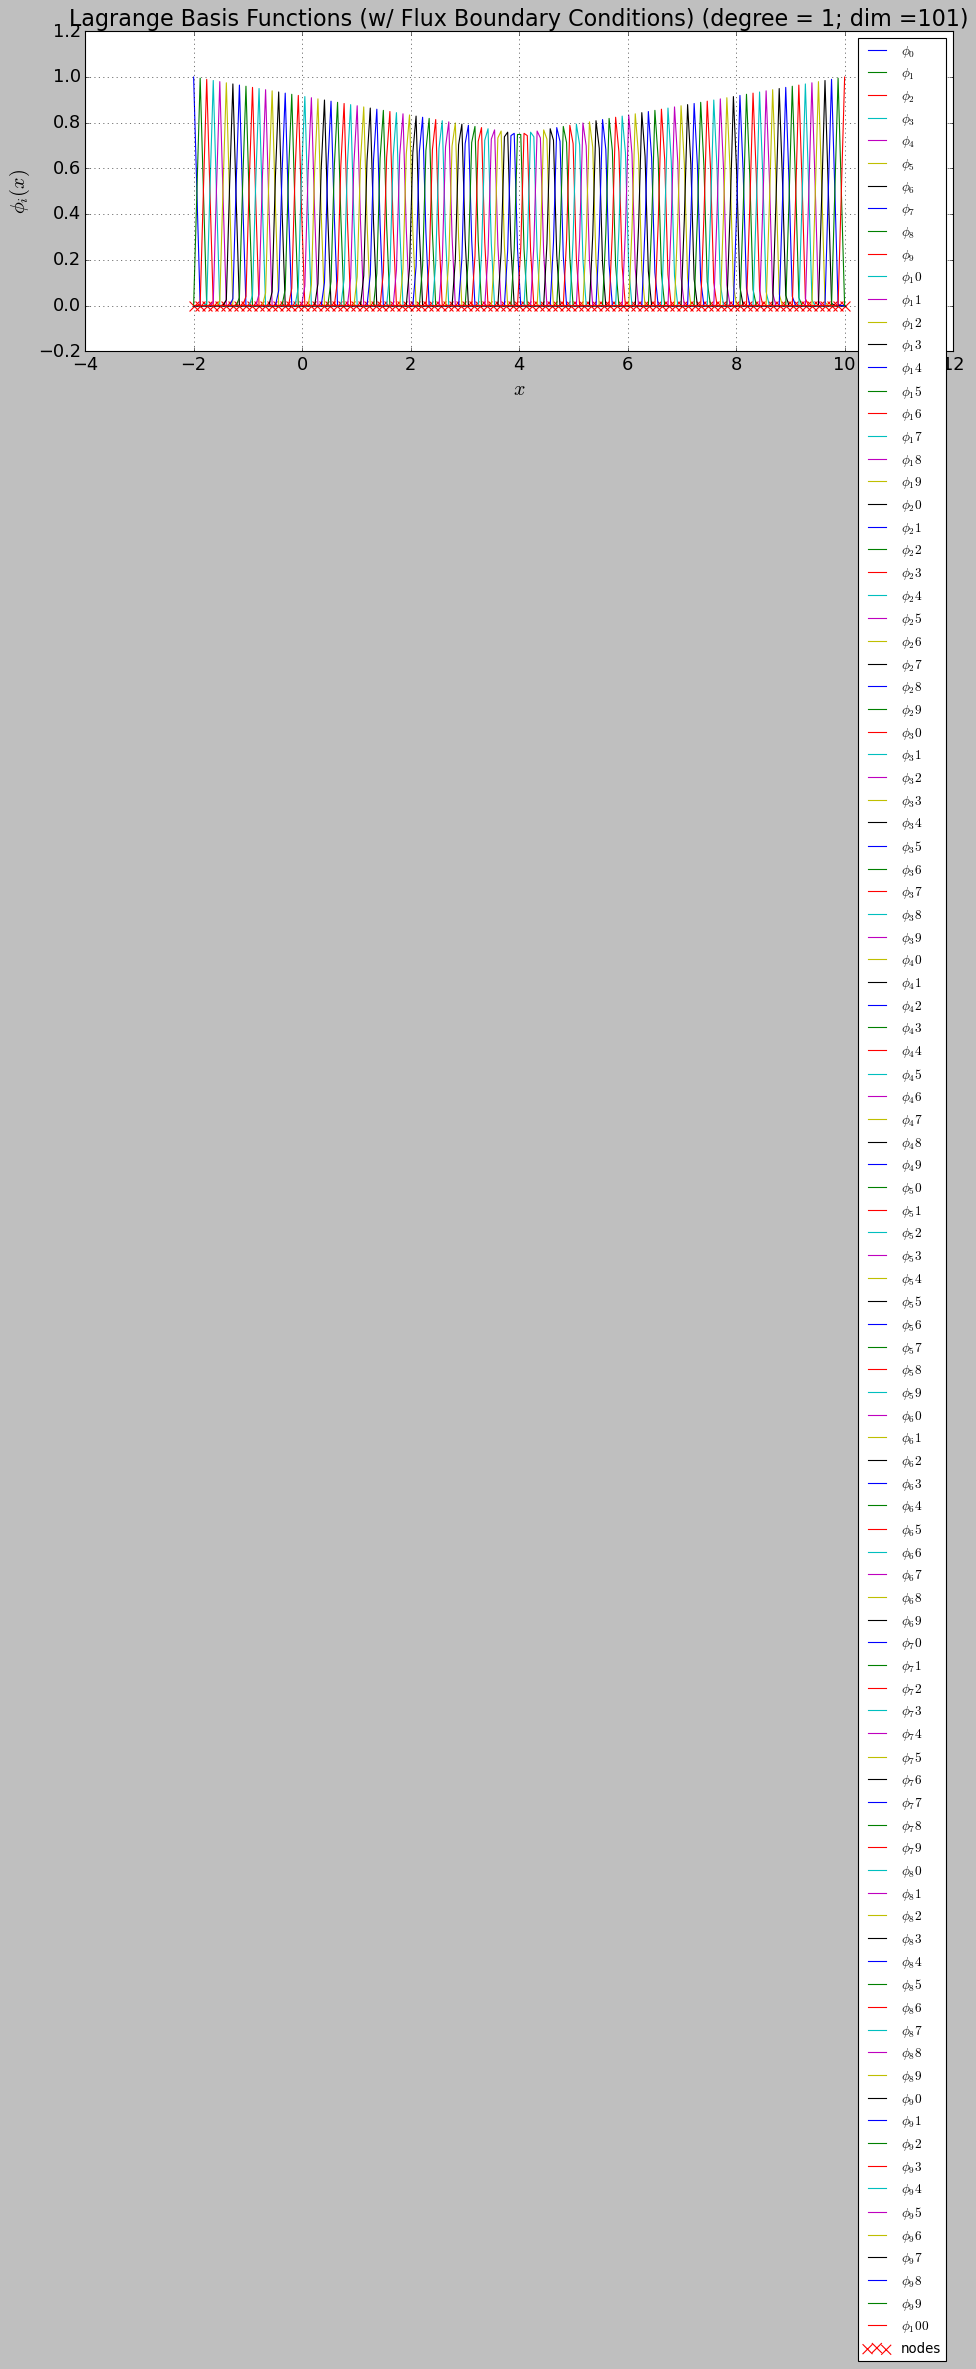

In [47]:
'''Test'''
import numpy as np
x_min = -2
x_max = 10

degree = 1
n_elem = 100

# It is implied here the boundary conditions are of type: flux
domain_partition = get_domain_partition(degree, n_elem, x_min, x_max)
parent_mapping = get_parent_mapping()
parent_basis_functions = get_parent_basis_functions()

phi_list = get_global_basis_functions(domain_partition, parent_mapping, parent_basis_functions, global_basis_function)

plot(title=r'Lagrange Basis Functions (w/ Flux Boundary Conditions) (degree = %i; dim =%i'%(degree, len(phi_list))+')')

## [Function Approximation](#toc)<a id="func-approx"></a>

This section covers implementation `python` code for function approximation using Lagrange finite element basis functions and the continuous least-squares residual covered in previous notebooks in this course.

### [Target Function](#toc)<a id="f"></a>

Given a *well-behaved* target function $f:[a,b]\rightarrow\Reals$, compute an approximant $g:[a,b]\rightarrow\Reals$.

# shape pts =  12


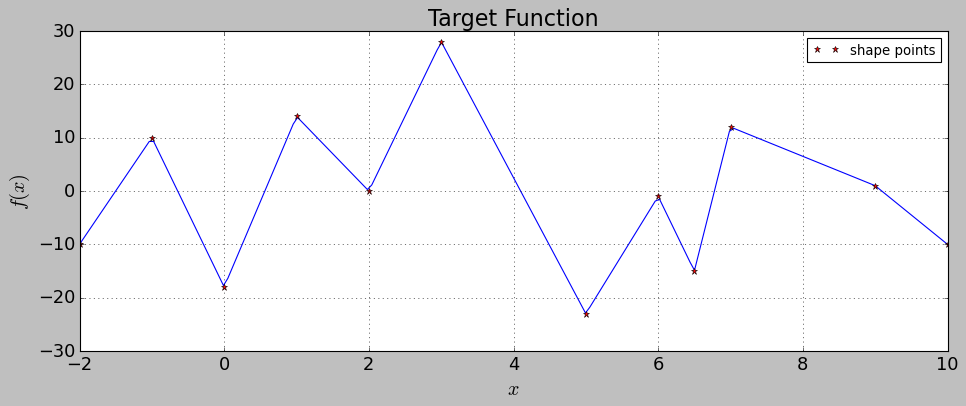

In [40]:
'''Generate the target function'''

try:    
    from engy_5310.toolkit import TargetFunction   
except ModuleNotFoundError:
    assert False, 'You need to provide your own code here. Bailing out.'

shape_pts = [(-2,-10), (-1,10), (0,-18), (1,14), (2,0), (3,28), (5,-23), (6, -1), (6.5, -15), (7,12), (9,1), (10,-10)]
print('# shape pts = ', len(shape_pts))

f = TargetFunction(shape_pts, type='linear')
  
f.plot(n_plot_pts=200, show_shape_pts=True, title='Target Function')

### [Inner Product](#toc)<a id="inner-prod"></a>

The inner products $(\phi_i,\phi_j)$ and $(f,\phi_i)$ are used repetitively when approximating a function via the continuous least-squares method. It pays off to implement a general `python` function for this operation. It can be readily computed using the global basis functions. This is rarely done this way since it is expensive. A much more effective element-by-element integration method will be described next in the course. For now the code below is a pedagogical way of demonstrating the implementation. In addition, the code below is independent of the degree of the Lagrange polynomial basis functions; no change in this code is needed when using higher-order degree polynomials.

In [18]:
'''Pedagogical inner product'''
from scipy.integrate import quad
def inner_product(u, v, patches):
    integrand = lambda x: u(x) * v(x)          
    inner_product = 0.0
    for nodes_x in patches:
        (inner_product_e, _) = quad(integrand, nodes_x[0], nodes_x[1])
        inner_product += inner_product_e           
    return inner_product

### [Gram Matrix](#toc)<a id="gram-matrix"></a>

Build the matrix of inner products of the basis functions, the *Gram matrix* or also called the *mass matrix*: ${(\Gmtrx)}_{i,j} = (\phi_i, \phi_j)$. The implementation below is expensive and provide here for pedagogical purposes. A much faster way will covered later, however it will be less direct.

In [19]:
'''Pedagogical Gram matrix'''
def get_gram_matrix(basis_func_list, domain_partition, inner_product):
    N = len(basis_func_list)
    patches = domain_partition[0]
    a_mtrx = np.zeros((N, N), dtype=np.float64)
    for i,phi_i in enumerate(basis_func_list):
        for j,phi_j in enumerate(basis_func_list):
            a_mtrx[i,j] = inner_product(phi_i, phi_j, patches)    
    return a_mtrx

In [31]:
'''Compute the Pedagogical Gram matrix'''
gram_mtrx = get_gram_matrix(phi_list, domain_partition, inner_product)

In [21]:
np.set_printoptions(precision=2, edgeitems=6, threshold=200, linewidth=150)
gram_mtrx

array([[0.2, 0.1, 0. , 0. , 0. , 0. , ..., 0. , 0. , 0. , 0. , 0. , 0. ],
       [0.1, 0.4, 0.1, 0. , 0. , 0. , ..., 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.1, 0.4, 0.1, 0. , 0. , ..., 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0.1, 0.4, 0.1, 0. , ..., 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.1, 0.4, 0.1, ..., 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0.1, 0.4, ..., 0. , 0. , 0. , 0. , 0. , 0. ],
       ...,
       [0. , 0. , 0. , 0. , 0. , 0. , ..., 0.4, 0.1, 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , ..., 0.1, 0.4, 0.1, 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , ..., 0. , 0.1, 0.4, 0.1, 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , ..., 0. , 0. , 0.1, 0.4, 0.1, 0. ],
       [0. , 0. , 0. , 0. , 0. , 0. , ..., 0. , 0. , 0. , 0.1, 0.4, 0.1],
       [0. , 0. , 0. , 0. , 0. , 0. , ..., 0. , 0. , 0. , 0. , 0.1, 0.2]])

In [22]:
'''Element-by-element assembly of the Gram matrix'''
def assemble_gram_matrix(a_mtrx, domain_partition, parent_mapping, parent_basis_func_list):
    
    n = len(parent_basis_func_list)
    local_to_global_node_id_map = domain_partition[2]
    
    local_a_mtrx = np.zeros((n, n), dtype=np.float64)
    
    for I in range(n):
        parent_basis_func_I = parent_basis_func_list[0][I]
        for J in range(n):
            integrand = lambda zeta: parent_basis_func_I(zeta) * parent_basis_func_list[0][J](zeta)
            (local_a_mtrx[I,J], _) = quad(integrand, -1, 1)
            
    for (e, gnode_ids) in enumerate(local_to_global_node_id_map):
        (x_0, x_1) = domain_partition[0][e]
        h_e = x_1 - x_0
        parent_mapping_jacobian = parent_mapping[1](h_e)
        for (I, i) in enumerate(gnode_ids):
            for (J, j) in enumerate(gnode_ids):
                a_mtrx[i,j] += local_a_mtrx[I,J] * parent_mapping_jacobian
                
    return a_mtrx

In [48]:
'''Compute the Gram matrix'''

N = len(phi_list) # this needs to be changed to the number of degrees of freedom or effective global basis functions

g_mtrx = np.zeros((N,N), dtype=np.float64)

g_mtrx = assemble_gram_matrix(g_mtrx, domain_partition, parent_mapping, parent_basis_functions)

In [49]:
g_mtrx

array([[0.04, 0.02, 0.  , 0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.02, 0.08, 0.02, 0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.02, 0.08, 0.02, 0.  , 0.  , ..., 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.02, 0.08, 0.02, 0.  , ..., 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.02, 0.08, 0.02, ..., 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.02, 0.08, ..., 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       ...,
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , ..., 0.08, 0.02, 0.  , 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , ..., 0.02, 0.08, 0.02, 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , ..., 0.  , 0.02, 0.08, 0.02, 0.  , 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.02, 0.08, 0.02, 0.  ],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.  , 0.02, 0.08, 0.02],
       [0.  , 0.  , 0.  , 0.  , 0.  , 0.  

In [50]:
print('||gram_mtrx - g_mtrx|| = ', np.linalg.norm(gram_mtrx-g_mtrx))

ValueError: operands could not be broadcast together with shapes (36,36) (101,101) 

### [Load Vector](#toc)<a id="load-vector"></a>

Build the load vector ${(\bvec)}_{i} = (f, \phi_i)$ by computing the inner product of $f$ with each basis function member.

In [51]:
'''Build load vector'''

b_vec = np.zeros(len(phi_list), dtype=np.float64)
patches = domain_partition[0]
for i, phi_i in enumerate(phi_list):
    b_vec[i] = inner_product(f, phi_i, patches)      

In [52]:
b_vec

array([-0.55, -0.91, -0.62, -0.34, -0.05,  0.24,  0.53,  0.82,  1.07,  0.93,  0.53,  0.12, -0.28, -0.68, -1.08, -1.49, -1.89, -1.96, -1.55, -1.08,
       -0.62, -0.16,  0.3 ,  0.76,  1.22,  1.57,  1.48,  1.28,  1.08,  0.87,  0.67,  0.47,  0.27,  0.1 ,  0.27,  0.67,  1.08,  1.48,  1.88,  2.28,
        2.69,  3.09,  3.2 ,  2.87,  2.5 ,  2.14,  1.77,  1.4 ,  1.03,  0.67,  0.3 , -0.07, -0.43, -0.8 , -1.17, -1.54, -1.9 , -2.27, -2.6 , -2.54,
       -2.23, -1.92, -1.6 , -1.28, -0.96, -0.65, -0.34, -0.29, -0.66, -1.06, -1.46, -1.56, -0.89, -0.12,  0.66,  1.3 ,  1.36,  1.28,  1.2 ,  1.12,
        1.04,  0.96,  0.89,  0.81,  0.73,  0.65,  0.57,  0.49,  0.41,  0.33,  0.25,  0.17,  0.06, -0.09, -0.25, -0.41, -0.57, -0.72, -0.88, -1.04,
       -0.57])

### [Optimal Combination Coefficients](#toc)<a id="cont-optimal-coeff"></a>

Compute the optimal coefficient vector by solving

\begin{equation*}
 \overset{(n\times n)}{\Gmtrx}\,\cvec^* = \bvec ,
\end{equation*}

which has a unique solution since the Gram matrix, $\Gmtrx$, is always full rank (linear independent basis functions).

In [53]:
'''Compute optimal coefficient vector'''

#c_star_vec = np.linalg.solve(gram_mtrx, b_vec)
c_star_vec = np.linalg.solve(g_mtrx, b_vec)

### [Results](#toc)<a id="cont-res"></a>

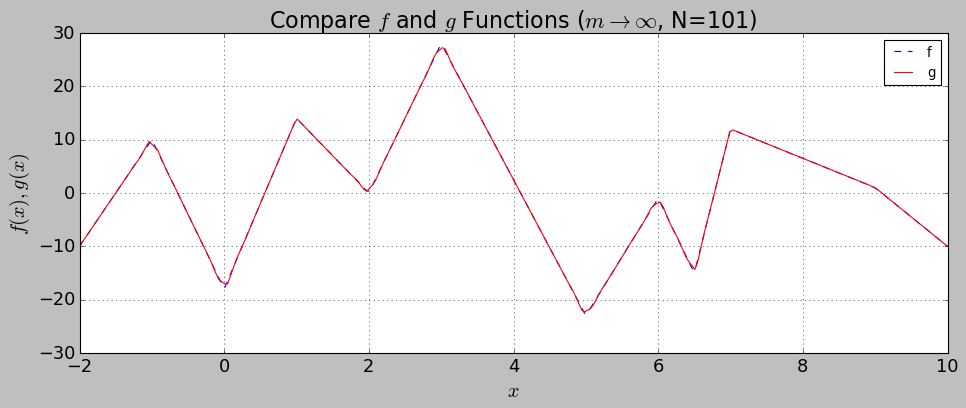

In [54]:
'''Plot comparison of f and g_best_vec'''

n_pts = 300
x_pts = np.linspace(x_min, x_max, n_pts)

eval_mtrx = np.zeros((n_pts,len(phi_list)), dtype=np.float64)
for (j,phi_j) in enumerate(phi_list):
    eval_mtrx[:,j] = phi_j(x_pts)
    
g_best = eval_mtrx@c_star_vec

f.plot(g=(x_pts,g_best), n_plot_pts=n_pts, g_line_style='plain', f_line_style='dashed', title=r'Compare $f$ and $g$ Functions ($m\rightarrow\infty$, N='+str(len(phi_list))+')')